In [ ]:
# This file uses LDA for topic modeling

In [1]:
import string
import numpy as np
import re
import pandas as pd
import seaborn as sns

# Gebsim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import warnings

# pyLDAvis
!pip install pyLDAvis
import pyLDAvis.gensim_models

# Coherence
from gensim.models.coherencemodel import CoherenceModel

warnings.filterwarnings("ignore")
from pprint import pprint

In [16]:
#Load df
data = pd.read_csv('./data/tripadvisor_hotel_reviews.csv')
nd_reviews = pd.read_csv('./data/reviews_clean.csv')

<AxesSubplot: xlabel='length', ylabel='Density'>

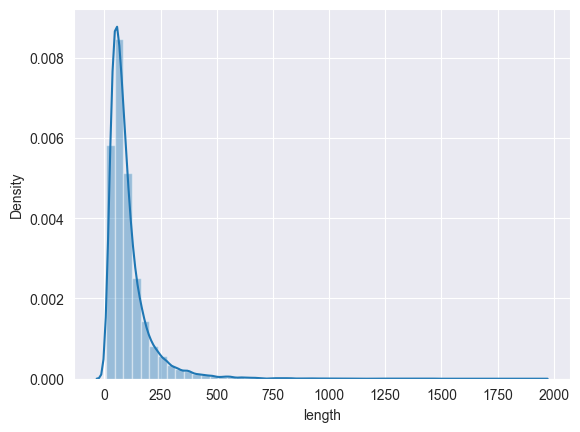

In [175]:
# It is medium text length, but the classical approach LDA-model
# might perform poorly on short texts like Tweets, Reddit posts , reviews and etc.
# So LDA might not be the best for our dataset
nd_reviews['length'] = nd_reviews.Review.apply(lambda row: len(row.split()))

sns.set_style(style="darkgrid")
sns.distplot(nd_reviews['length'])

# In LDA, documents are considered to be a mixture of topics.
# Short text only deals with one topic (most of the time),
# so this assumption is not reliable anymore.
# Shorter text means fewer data to rely on during the LDA inference steps.



In [3]:
# Some downloads
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

ERROR: To modify pip, please run the following command:
c:\programmering\ntnu\python\oblig4\jupytiertest\scripts\python.exe -m pip install -U pip setuptools wheel



  Using cached pip-23.0-py3-none-any.whl (2.1 MB)
     -------------------------------------- 12.8/12.8 MB 399.2 kB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [21]:
# Another test of pre-process:
data['review_list'] = data.Review.values.tolist()

# remove characters
data['review_list'] = [re.sub('\s+', ' ', sent) for sent in data['review_list']]
data['review_list'] = [re.sub("\'", "", sent) for sent in data['review_list']]


def sent_to_words(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text = [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text


tokens_reviews = list(sent_to_words(data['review_list']))

tokens_reviews = make_n_grams(tokens_reviews)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# gensim stop-words and add stop-words based on texts
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if
             word not in gensim.parsing.preprocessing.STOPWORDS.union(
                 {'from'})] for doc in texts]

"""
'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know',
                  'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                  'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even',
                  'right', 'line', 'even', 'also', 'may', 'take', 'come', 'also', 'meanwhile', 'however', 'time',
                  'hour', 'soon', 'day', 'book',
                  'there', 'hotel', 'room', 'leave',
                  'arrive',
                  'place', 'stay', 'staff', 'location',
                  'service', 'come', 'check',
                  'ask', 'lot', 'thing',
                  'soooo', 'add', 'rarely',
                  'use', 'look', 'minute',
                  'bring', 'need', 'world',
                  'think', 'value', 'include'

"""


# , 'arrive', 'place', 'stay', 'staff', 'location', 'service'

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


# do lemmatization keeping only noun, vb, adv
# because adj is not informative for reviews topic modeling
reviews_lemmatized = lemmatization(tokens_reviews, allowed_postags=['NOUN', 'VERB', 'ADV'])

# remove stop words after lemmatization
reviews_lemmatized = remove_stopwords(reviews_lemmatized)

data_ready = reviews_lemmatized



In [26]:
#LDA MODEL

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

texts = data_ready

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=8,
                                       random_state=100,
                                       chunksize=10,
                                       passes=10,
                                       alpha='symmetric',
                                       eta=0.1,
                                       iterations=100,
                                       per_word_topics=True)

In [23]:
# pyLDAvis visualization:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.327481  0.068902       1        1  57.968779
4      0.297965 -0.047271       2        1  37.425101
6     -0.003308 -0.092225       3        1   3.538358
1     -0.124616  0.014652       4        1   0.222416
0     -0.124623  0.014608       5        1   0.216669
3     -0.124334  0.013792       6        1   0.211154
2     -0.124287  0.013757       7        1   0.209287
5     -0.124279  0.013785       8        1   0.208236, topic_info=             Term          Freq         Total Category  logprob  loglift
14          hotel  47054.000000  47054.000000  Default  30.0000  30.0000
3437       resort   8490.000000   8490.000000  Default  29.0000  29.0000
3474        beach   7840.000000   7840.000000  Default  28.0000  28.0000
120          tell   3074.000000   3074.000000  Default  27.0000  27.0000
707          pool   8090.000000   8090.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
26283  gran_bahia      0.244166     12.744811   Topic8  -9.3015   2.2192
10697    populate      0.229105      9.496019   Topic8  -9.3652   2.4498
1638        moore      0.221020      6.748217   Topic8  -9.4011   2.7555
9177       refuge      0.218443     13.274780   Topic8  -9.4129   2.0672
8957         aqua      0.218534     45.807794   Topic8  -9.4124   0.8290

[458 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
15283      1  0.256223   absoutly
15283      2  0.256223   absoutly
15283      3  0.256223   absoutly
29461      1  0.298364   acadamie
29461      2  0.298364   acadamie
...      ...       ...        ...
28538      2  0.284941  yogurtcon
28538      3  0.284941  yogurtcon
28542      1  0.266155  zawodniak
28542      2  0.266155  zawodniak
28542      3  0.266155  zawodniak

[1244 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 7, 2, 1, 4, 3, 6])

In [139]:
# Print the topics and the tokens and weight belonging to the topics
#pprint(lda_model.print_topics())


In [27]:
# Test coherence score (u_mass and c_v)

"""
Coherence measures the relative distance between words within a topic.
There are two major types C_V typically 0 < x < 1 and uMass -14 < x < 14.
It's rare to see a coherence of 1 or +.9 unless the words being measured are either identical words or bigrams.
Like United and States would likely return a coherence score of ~.94 or hero and hero would return a coherence of 1.
The overall coherence score of a topic is the average of the distances between words.

Low coherence fixes:

- Adjust your parameters alpha = .1, beta = .01 or .001, random_state = 123, etc
- Get better data
- At .4 we probably have the wrong number of topics
"""

cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
u_mass_score = cm.get_coherence()

#Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
c_v_score = coherence_model_lda.get_coherence()

print('U_mass Score: ', u_mass_score,
      '\nC_v Score: ', c_v_score)


U_mass Score:  -2.5675096033477733 
C_v Score:  0.3330019639871963


In [24]:
# Lists documents most dominant topics and its percentage contribution in each document.

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7,0.9813,"hotel, room, stay, staff, location, night, breakfast, walk, service, bed","[hotel, parking, deal, stay, hotel, anniversary, arrive, evening, advice, review, valet_parking,..."
1,1,7,0.7486,"hotel, room, stay, staff, location, night, breakfast, walk, service, bed","[charge, diamond_member, decide, chain, shoot, anniversary, seattle, start, book, suite, pay, we..."
2,2,7,0.8121,"hotel, room, stay, staff, location, night, breakfast, walk, service, bed","[room, experience, level, positive, bathroom, bed, housekeeping, staffnegative, malfunction, des..."
3,3,7,0.7807,"hotel, room, stay, staff, location, night, breakfast, walk, service, bed","[stay, time, hotel, stroll, downtown, shopping, area, room, sign, animal, hair, smell, sleep, ar..."
4,4,7,0.6056,"hotel, room, stay, staff, location, night, breakfast, walk, service, bed","[stay, stay, game, downfall, view, building, complain, room, staff, book, hotel, website, seahaw..."


In [25]:
# Lists all topics and displays the most central tokens and representative sentence for each topic.

pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

# OKEY so almost all the top tokens are the same. So this sucks ass idk.

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.8538,"plage, employe, viaduct, courthouse, fonda, loom, itally, griffin, artois, obsession","[touriste, boutique, sur, plage, achet]"
1,2,0.7450,"et, vraiment, casa_fuster, fantastique, figuere, monjuic, cloister, casa_mila, prix, intime","[hotel, moment, hor, temp, vegetation, magnifique, bungalow, intime, et, ravissant]"
2,3,0.5084,"publico, josue, aquafrenzy, lodge, rambeller, staffer, avila, zawodniak, scruptiously, foof","[love, amenity, sevice, history, bordello, attatche, city, ooze, gem, stay, ritz_carlton, orient..."
3,4,0.9991,"room, resort, beach, pool, food, day, time, restaurant, people, service","[vacation, sireni, arrival, flight, review, arrive, rd, stay, book, apple_vacation, deal, day, n..."
4,6,0.9326,"tell, manager, check, desk, ask, charge, phone, reservation, finally, room","[word, customer, service, tell, caller, check, guest, turn, delivery, desk, agent, laugh]"
5,7,0.9970,"hotel, room, stay, staff, location, night, breakfast, walk, service, bed","[new_york, location, partner, book, end, meeting, parent, holiday, spend, lot, time, research, m..."


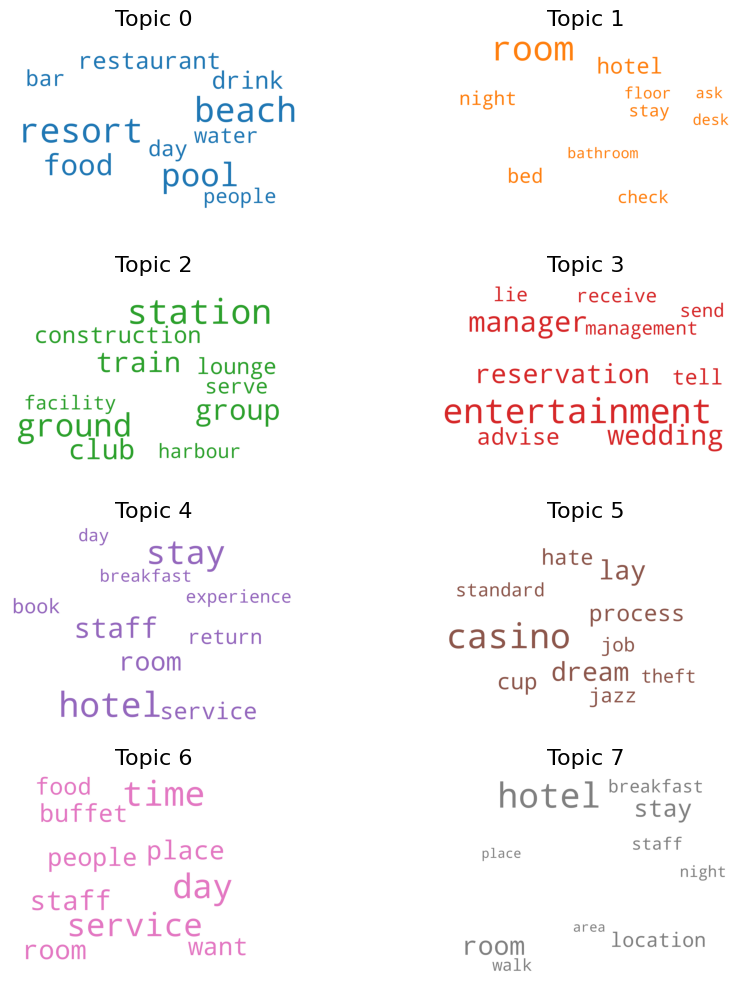

In [29]:
# 1. Wordcloud of top N words in each topic

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
    background_color='white',
    width=2500,
    height=1800,
    max_words=10,
    colormap='tab10',
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

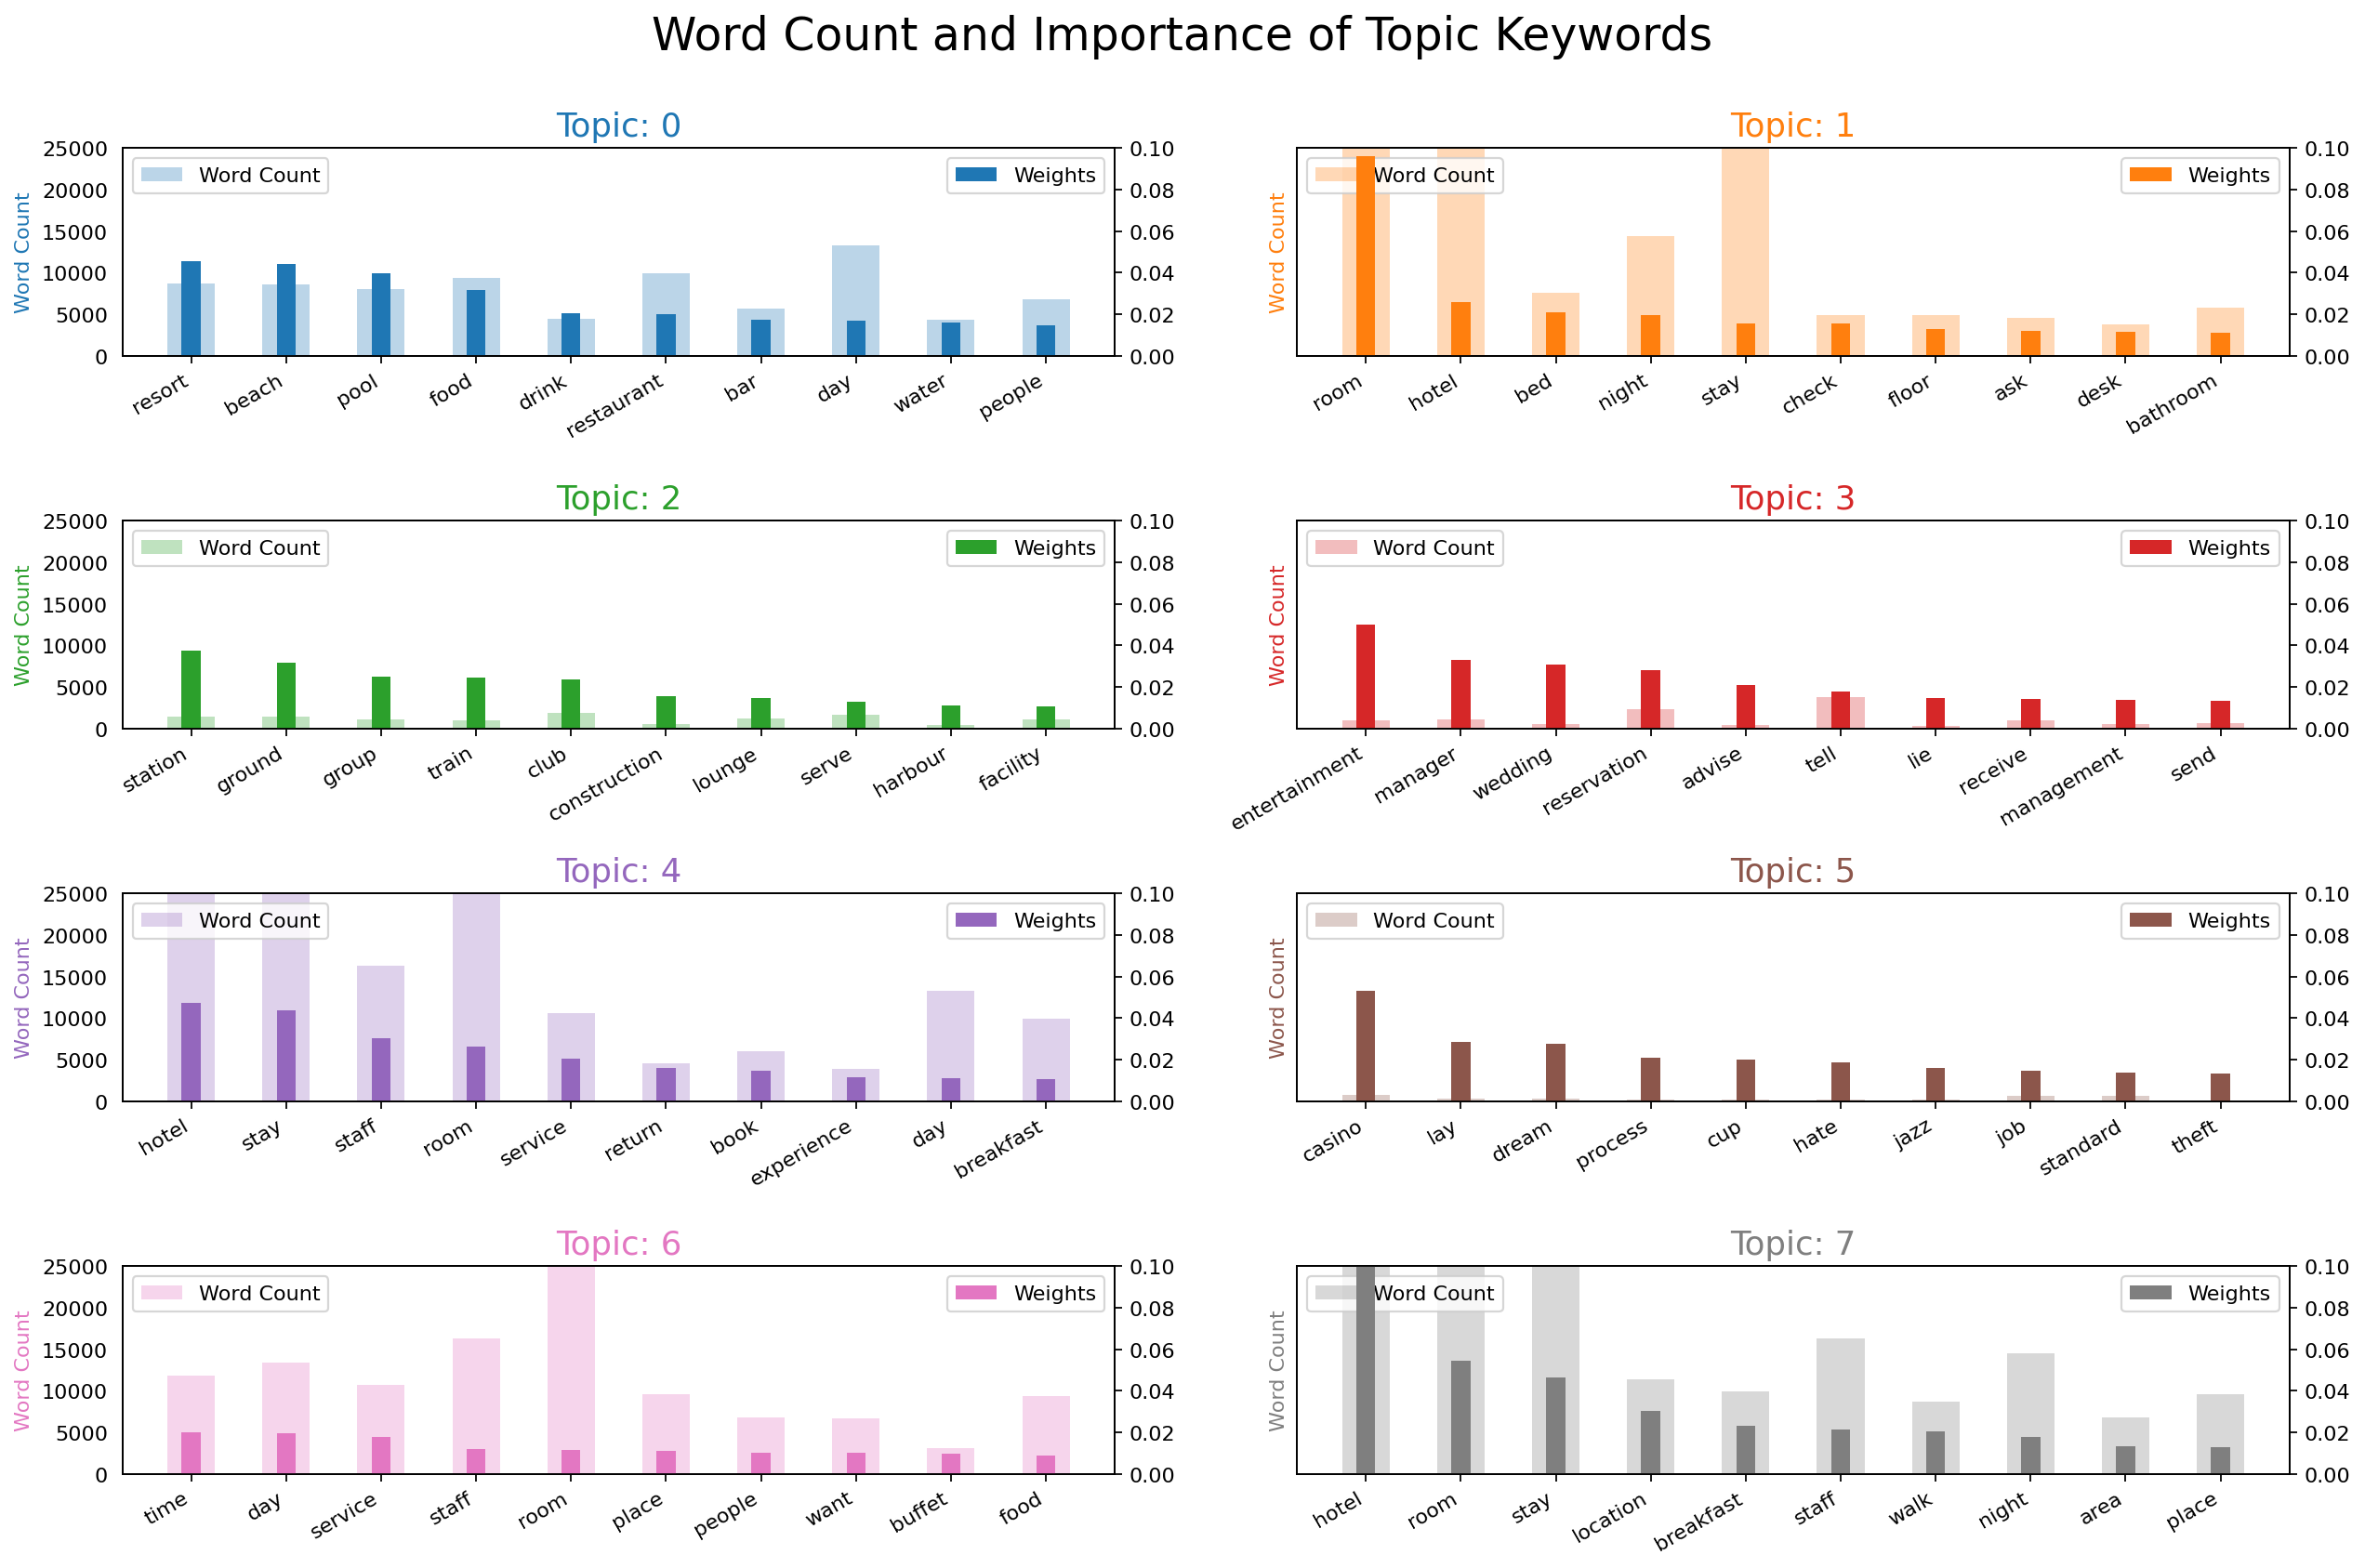

In [28]:
# Word Counts of Topic Keywords - Creating graphs to see how many words are in the different topics.

from collections import Counter

topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16, 10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3,
           label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id == i, :], color=cols[i], width=0.2,
                label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.1);
    ax.set_ylim(0, 25000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left');
    ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()


In [145]:
#For eval:
# 1. Are the identified topics understandable?
# 2. Are the topics coherent?

# We have human judgment, quantitative metrics and mixed.
# Human: Eg wordcloud

In [ ]:
# Finding optimal k-topics
# This can take a while it seems to run idk

from gensim.models import LdaModel


def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           alpha=0.01,
                                           eta=0.01)
        #= LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=0.01, eta=0.01)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=1,
                                                        limit=20, step=1)
# Show graph
import matplotlib.pyplot as plt

limit = 20
start = 1
step = 1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

"""
Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful
and interpretable topics.
Picking an even higher value can sometimes provide more granular sub-topics.
If you see the same keywords being repeated in multiple topics,
it’s probably a sign that the ‘k’ is too large.

Means of LDA coherence score I found online and have no idea if is correct at all lol:
0.3 is bad
0.4 is low
0.55 is okay
0.65 might be as good as it is going to get
0.7 is nice
0.8 is unlikely
0.9 is probably wrong
"""
